# Introduction

**Objective:**  
Engineer a product recommendation system for an e-commerce website to increase customer retention and sales.

**Featured Techniques:**
* Feature Engineering
* Collaborative Filtering
* Surprise Package SVD

**Methodology:**  
Users are separated into repeat customers and first time customers and the recommendation system works as follows. 
* Repeat Customers
    * Collaborative filtering recommendation
    * Hot Products
    * Popular in your area
    
* New Customers
    * Hot products
    * Popular in your area

**Data:** 
https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv

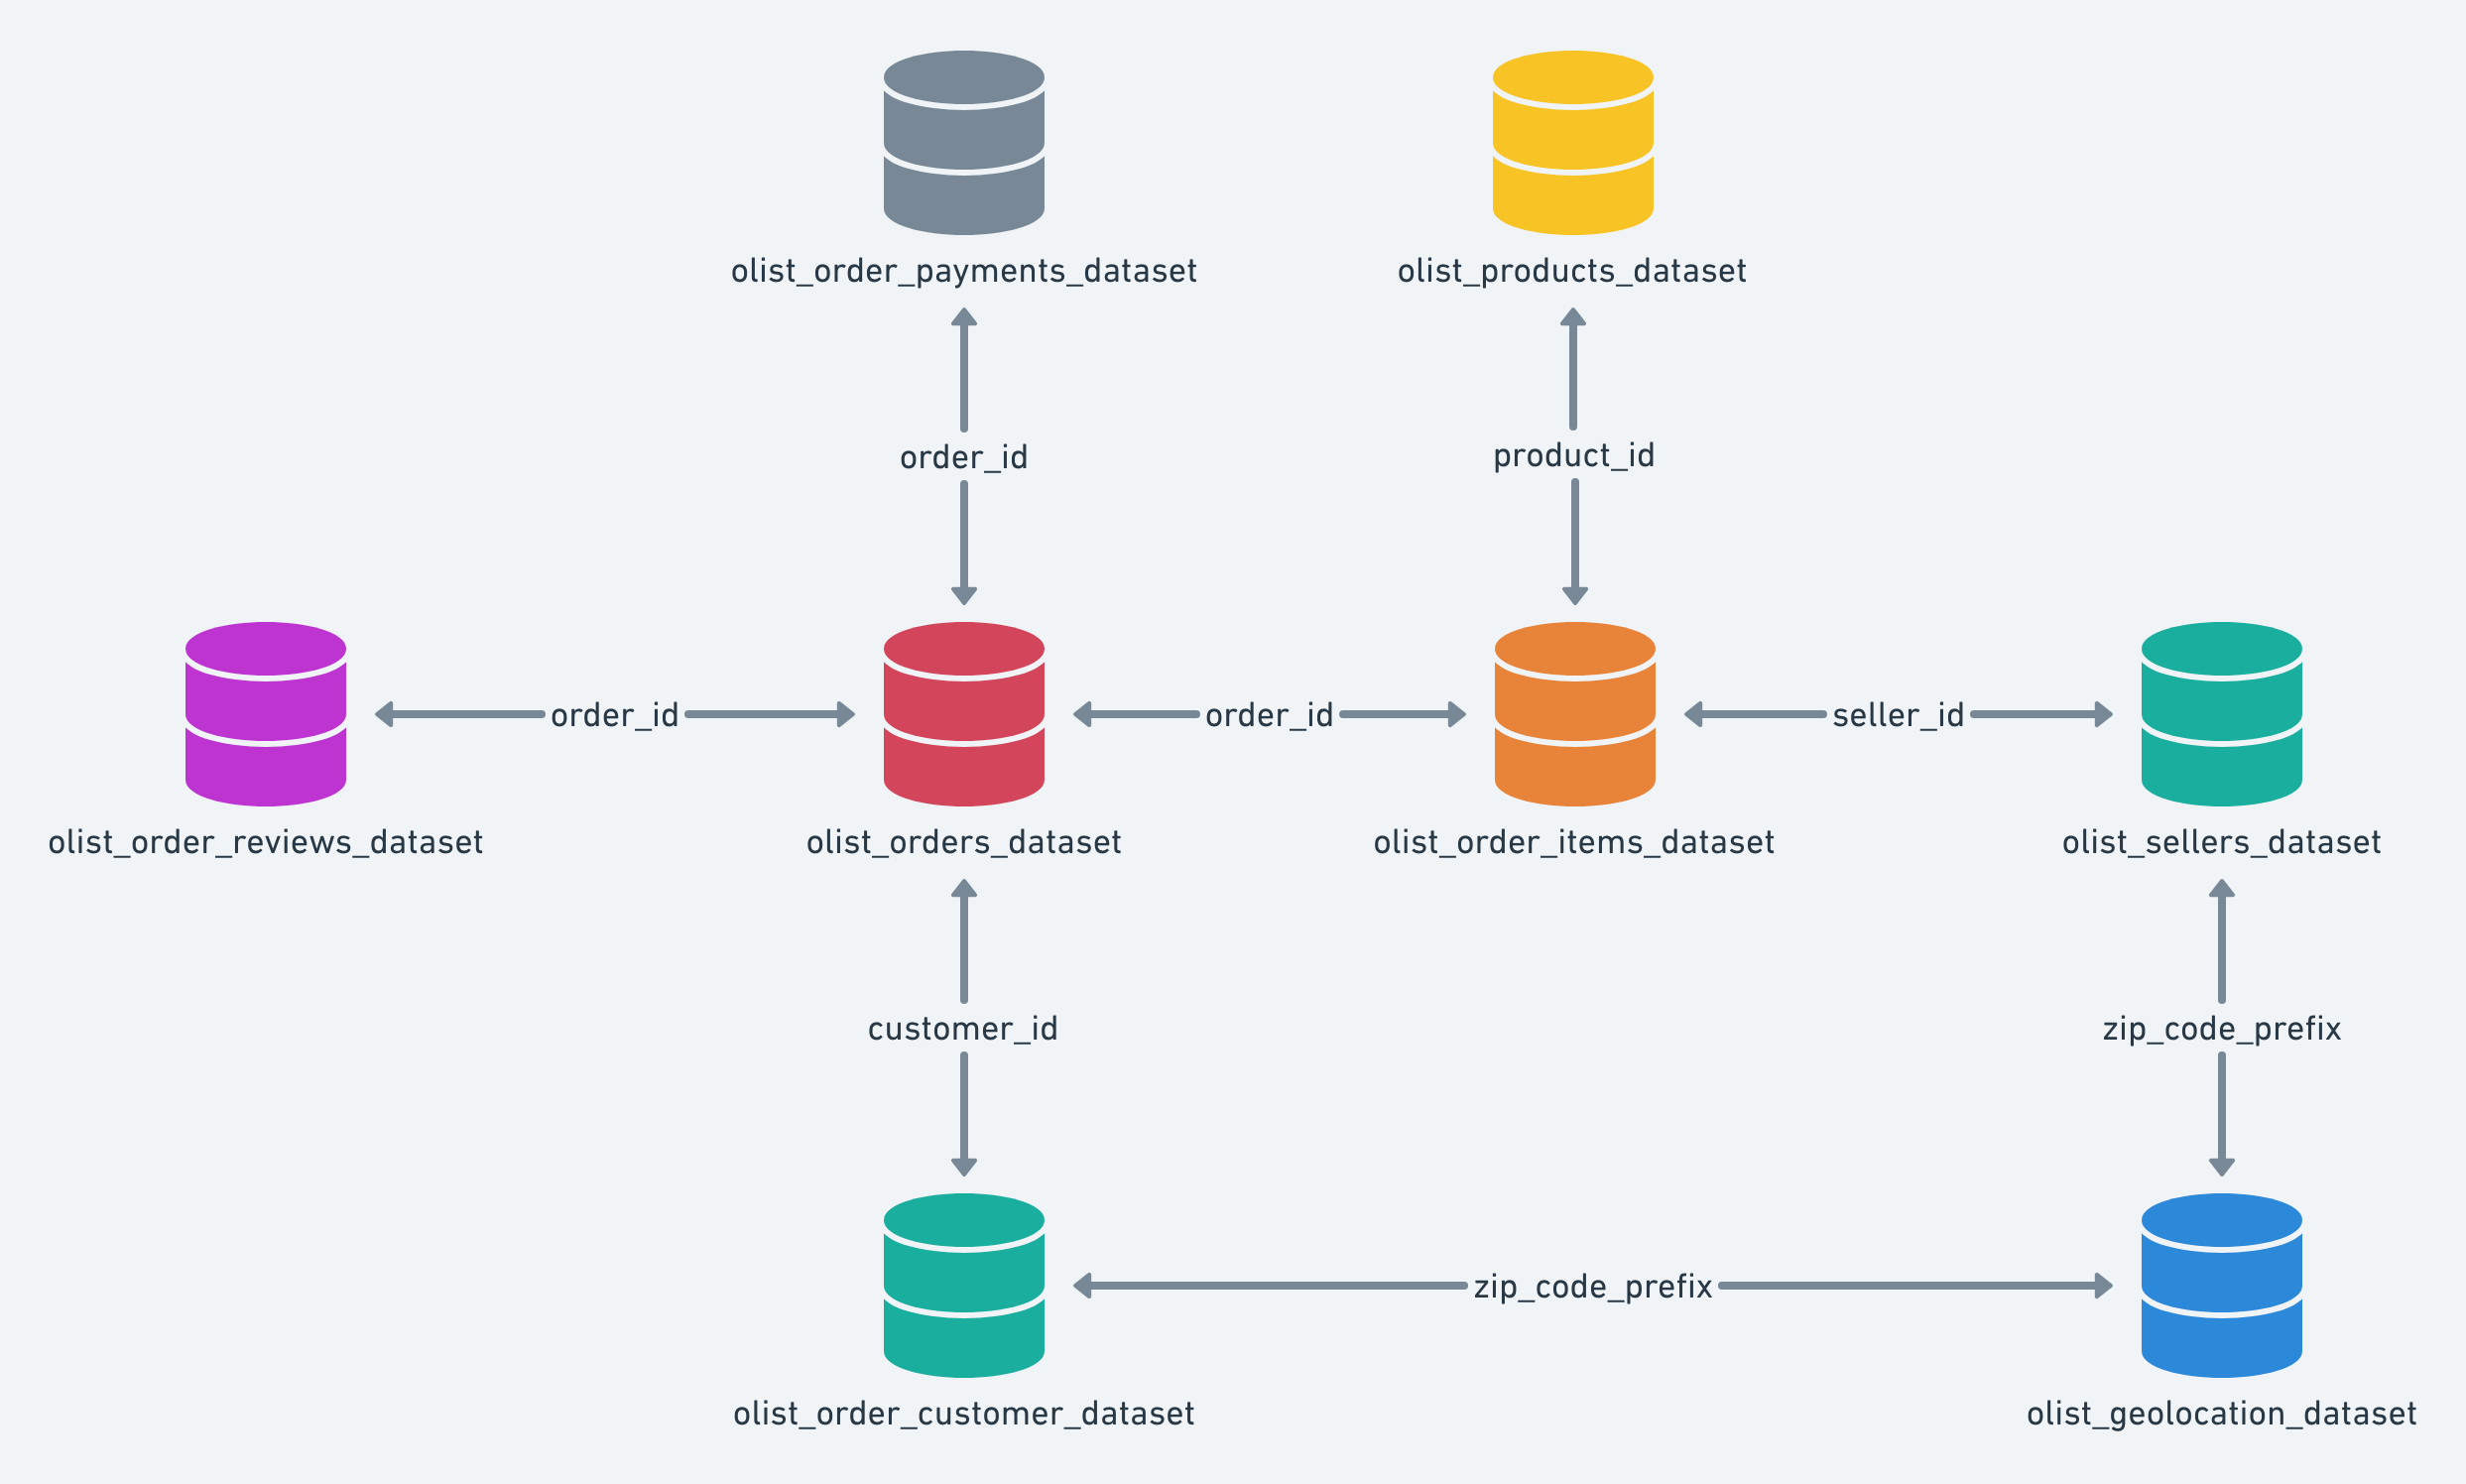

In [184]:
# Display database schema in ms-access
from IPython.display import Image
Image("data_mapping.png")

In [185]:
# call function stored separately that connects to ms-access database
import pyodbc
access_engine = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=C:\lgProgam\DataSet\Brazilian E-Commerce Public Dataset by Olist\eCommerce_BRZ.accdb;')


In [186]:
import pandas as pd
import numpy as np
from collections import defaultdict

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from scipy import stats

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from datetime import datetime

#from connect_to_aws import connect

In [187]:
# Connecting to ms-ac

# Loading and Cleaning Data

## Querying Data With SQL

In [188]:
def query_accessdb(query, access_engine):
    #query = "SELECT * FROM eComDataset"
    return pd.read_sql(query, access_engine)

In [189]:
query = """
        SELECT 
            customers.customer_unique_id, 
            customers.customer_zip_code_prefix, 
            customers.customer_city,
            customers.customer_state,
            order_items.order_id,
            order_items.product_id,
            order_items.seller_id,
            order_items.price,
            orders.order_purchase_timestamp,
            orders.order_delivered_customer_date,
            orders.order_estimated_delivery_date,
            order_payments.payment_type,
            order_payments.payment_installments,
            order_payments.payment_value,
            order_reviews.review_score,
            products.product_weight_g,
            product_category.product_category_name_english,
            sellers.seller_zip_code_prefix,
            sellers.seller_state,
            sellers.seller_state
FROM 
((((((customers 

INNER  JOIN orders  
ON orders.customer_id=customers.customer_id)

INNER JOIN order_reviews  
ON order_reviews.order_id=orders.order_id) 

INNER  JOIN order_items
ON order_items.order_id=orders.order_id )

INNER  JOIN order_payments
ON order_payments.order_id=orders.order_id )

INNER  JOIN products
ON products.product_id=order_items.product_id)

INNER  JOIN product_category
ON product_category.product_category_name=products.product_category_name )

INNER  JOIN sellers
ON sellers.seller_id=order_items.seller_id ;
          
            
        """

olist_data = query_accessdb(query, access_engine)

In [190]:
# Save dataset to csv file
olist_data.to_csv('data/01_olist_accessdb_pulled.csv')

In [191]:
# If needed, unhash to load dataset
# olist_data = pd.read_csv('data/01_olist_aws_pulled.csv')

## Viewing and Cleaning

In [192]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43891 entries, 0 to 43890
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             43891 non-null  object        
 1   customer_zip_code_prefix       43891 non-null  object        
 2   customer_city                  43891 non-null  object        
 3   customer_state                 43891 non-null  object        
 4   order_id                       43891 non-null  object        
 5   product_id                     43891 non-null  object        
 6   seller_id                      43891 non-null  object        
 7   price                          43891 non-null  object        
 8   order_purchase_timestamp       43891 non-null  datetime64[ns]
 9   order_delivered_customer_date  42923 non-null  object        
 10  order_estimated_delivery_date  43891 non-null  datetime64[ns]
 11  payment_type   

In [193]:
#olist_data = olist_data.drop(columns=['Unnamed: 0', 'seller_state.1'])

In [194]:
# some purchases are payed with by vouchers which causes them to split into many lines of
# smaller payments. To normalize with the rest of the data, combining these values into 
# one total payment value

def create_total_payment_value(data):
    data['total_payment'] = data['payment_value'].groupby(data['order_id']).transform('sum')
    data= data.drop('payment_value', axis=1)
    return data

In [195]:
olist_data = create_total_payment_value(olist_data)

In [196]:
def duplicates(data):
    """
    Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values.
    """
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [197]:
olist_data = duplicates(olist_data)

There are 4713 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 39178 rows


In [198]:
# Convert order timestamp to datetime 
def convert_to_datetime(data):
    """
    Converts order_purchase, order_delivered, and order_estimated_delivery_date to 
    datetime objects.
    """
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp, 
                                                     format="%Y/%m/%d %H:%M:%S")
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    return data

olist_data = convert_to_datetime(olist_data)

In [199]:
# Adding 99% to 7 digit summary to understand how drastic the max_price outlier is
olist_data.describe([.75,.99])

,payment_installments,review_score,product_weight_g,total_payment
count,39178.000000,39178.000000,39178.000000,39178.000000
mean,2.935500,4.067819,2096.719128,228.236204
std,2.733139,1.362710,3749.016810,580.588911
min,1.000000,1.000000,0.000000,9.000000
50%,2.000000,5.000000,675.000000,113.000000
75%,4.000000,5.000000,1800.000000,212.000000
99%,10.000000,5.000000,18161.500000,1968.920000
max,24.000000,5.000000,30000.000000,45240.000000


In [200]:
# For now, not removing outliers but note that price and payment values both contain significan outliers

In [201]:
# Save to CSV to access later
olist_data.to_csv('data/cleaned_olist_data.csv', index=False)

In [202]:
# Unhash to access cleaned olist dataset
olist_data=pd.read_csv('data/cleaned_olist_data.csv')
print(olist_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39178 entries, 0 to 39177
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             39178 non-null  object 
 1   customer_zip_code_prefix       39178 non-null  int64  
 2   customer_city                  39178 non-null  object 
 3   customer_state                 39178 non-null  object 
 4   order_id                       39178 non-null  object 
 5   product_id                     39178 non-null  object 
 6   seller_id                      39178 non-null  object 
 7   price                          39178 non-null  float64
 8   order_purchase_timestamp       39178 non-null  object 
 9   order_delivered_customer_date  38323 non-null  object 
 10  order_estimated_delivery_date  39178 non-null  object 
 11  payment_type                   39178 non-null  object 
 12  payment_installments           39178 non-null 

# EDA

In [203]:
olist_blue  = '#0C29D1'
olist_green = '#0CC78B'

## Consumers

In [204]:
def general_customer_info(data):
    """Returns number of unique and repeat customers in the dataset."""
    print("Number of unique customers:", data.customer_unique_id.nunique())
    
    customer_count = data.customer_unique_id.value_counts()
    print("Number of repeat customers:", customer_count[customer_count > 1].count())

    return

general_customer_info(olist_data)

Number of unique customers: 36259
Number of repeat customers: 2485


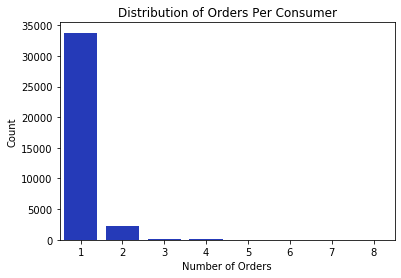

In [205]:
# Distribution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)
#print(orders_per_consumer.head(10))

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distribution of Orders Per Consumer');

In [206]:
# Customer locations throughout Brazil

def customer_geography(data):
    customer_locations = pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))
    print (customer_locations)
    #(olist_data)
    customer_locations = customer_locations.reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})
 
    print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")
    
    top_ten_cities = customer_locations.city[:10]
    customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

    print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

    return customer_locations, top_ten_cities

customer_locations, top_ten_cities = customer_geography(olist_data)

                        customer_city
sao paulo                        6119
rio de janeiro                   2679
belo horizonte                   1083
brasilia                          845
curitiba                          602
...                               ...
sao luis do curu                    1
monte alverne                       1
bom jesus do querendo               1
sao joao do manteninha              1
engenheiro passos                   1

[2929 rows x 1 columns]
There are 2929 unique customer cities.

The majority of customers, 35.2 percent, live in the top ten cities.



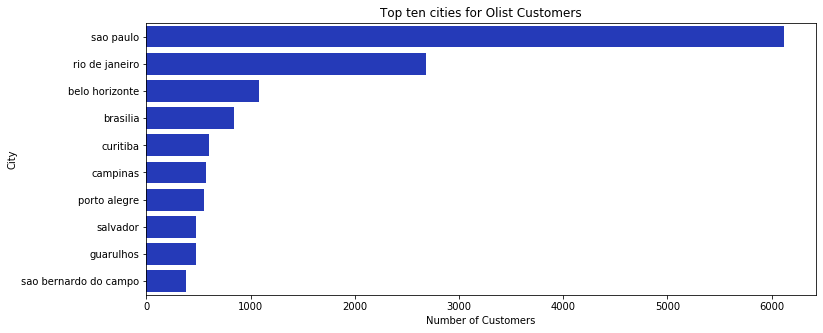

In [207]:
# plot top cities
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## Orders

In [208]:
def convert_to_datetime(data):
    """Returns the dataframe with time-stamped columns converted to datetime objects."""

    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp,
                                                   format="%Y/%m/%d %H:%M:%S")
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date,
                                                        format="%Y/%m/%d %H:%M:%S")
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date,
                                                        format="%Y/%m/%d %H:%M:%S")
    return data

olist_data = convert_to_datetime(olist_data)

In [209]:
# Number of orders per day

def order_per_day(data):
    # order_per_day = data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])
    #print (data.head())
    order_per_day = data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])
        
    print(f"Avg. number of orders per day: {np.mean(order_per_day)[0]}")
    
    return order_per_day

order_per_day = order_per_day(olist_data)

Avg. number of orders per day: 64.01633986928104


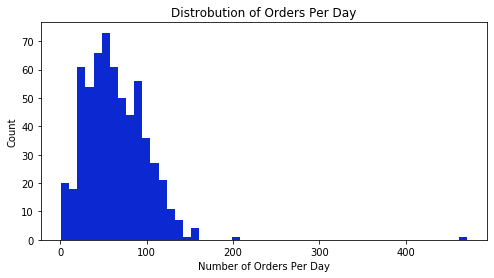

In [210]:
# Distribution of orders per day
plt.figure(figsize=(8,4))
plt.hist(order_per_day['count'], bins=50, color=olist_blue)
plt.xlabel('Number of Orders Per Day')
plt.ylabel('Count')
plt.title('Distrobution of Orders Per Day');

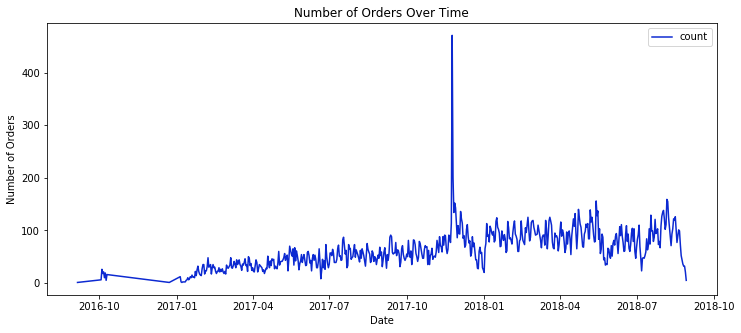

In [211]:
# plot number of orders over time
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
order_per_day.plot(ax=ax, use_index=True, color=olist_blue)
ax.set(xlabel='Date', ylabel='Number of Orders', title='Number of Orders Over Time');

There is a spike in orders around Christmas of 2017 but otherwise we see a pattern of general inflation of orders 

order_id
a000067196006b1ac2a467ba2156b22d     71
a001b4bdccb41f62d0c780dcfa1f6ab1     64
a001b704f3b4f4d26206555271f83e45     69
a0034faea6e79d2ed8d8e99279c443b8     90
a004b1039c9c568bb02a60cc915a9a5f    159
Name: total_payment, dtype: int64
Avg. purchase price: 204.9805328983143


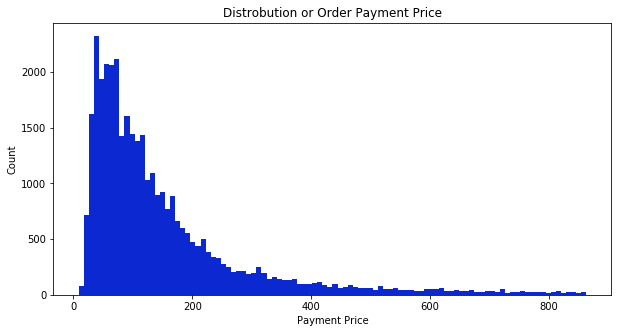

In [212]:
# Each line item represents a single item in an order. 
# Group by order_id to find total purchase price for all orders

def purchase_payment_val(data):
    
    purchase_payments = data.groupby('order_id').total_payment.max()
    print(purchase_payments.head())

    print(f"Avg. purchase price: {purchase_payments.mean()}")
    
    return purchase_payments

purchase_payments = purchase_payment_val(olist_data)

# view purchase price removing outliers in the top 3%
q_97 = purchase_payments.quantile(.97)
payments_97 = purchase_payments[purchase_payments < q_97]

# plot distrobution
plt.figure(figsize=(10,5))
plt.hist(payments_97, bins=100, color=olist_blue)
plt.xlabel('Payment Price')
plt.ylabel('Count')
plt.title('Distrobution or Order Payment Price');

In [213]:
# Number of items per order
def items_per_order(data):
    item_orders = data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')
    avg_items_per_order = item_orders.mean()
    print(f"Average number of items per order: {avg_items_per_order}")
    return avg_items_per_order

avg_items_per_order = items_per_order(olist_data)

Average number of items per order: count    1.065198
dtype: float64


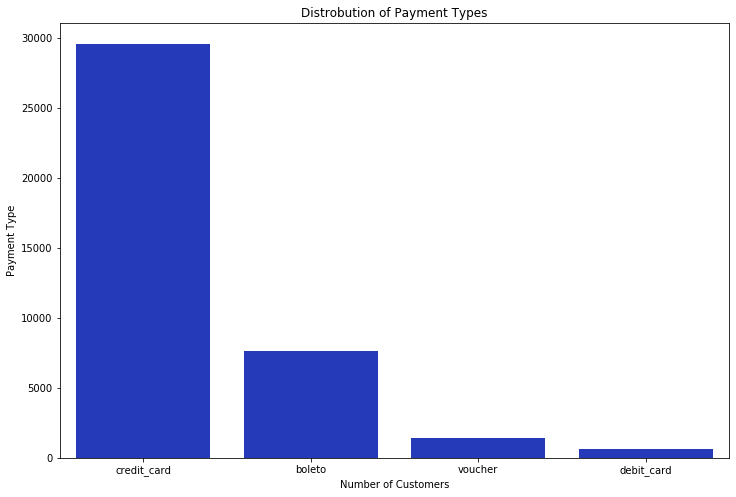

In [214]:
# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

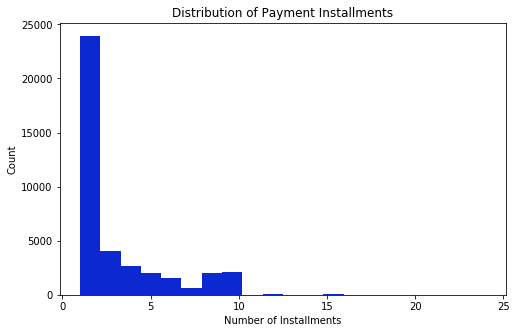

In [215]:
# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distribution of Payment Installments');

## Sellers

Avg. number of sales per seller: 15.76579476861167

The top 10 sellers account for 14.17 percent of the total sales

The top seller has 752 sales


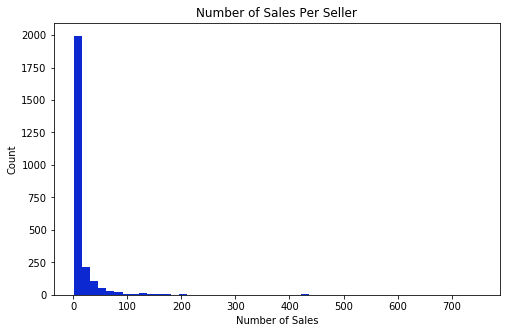

In [216]:
def sales_per_seller(data):
    """
    Returns the average number of sales per Olist seller, the magnitude of the top 10 sellers,
    and the number of sales that the top seller has made.
    """
    
    sales_per_seller = data.groupby('seller_id')['order_id'].count()
    print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")
    
    top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
    sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

    print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

    print(f"The top seller has {top_ten_sellers[0]} sales")

    return sales_per_seller

sales_per_seller = sales_per_seller(olist_data)


plt.figure(figsize=(8,5))
plt.hist(sales_per_seller, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

## Products

Number of unique products: 17437

Average price per product: 124.77451401296646

Average sales per product: 2.246831450364168

Top ten selling products:
99a4788cb24856965c36a24e339b6058    190
aca2eb7d00ea1a7b8ebd4e68314663af    163
53b36df67ebb7c41585e8d54d6772e08    130
422879e10f46682990de24d770e7f83d    118
53759a2ecddad2bb87a079a1f1519f73    118
d1c427060a0f73f6b889a5c7c61f2ac4    112
2b4609f8948be18874494203496bc318    111
154e7e31ebfa092203795c972e5804a6    109
389d119b48cf3043d311335e499d9c6b    108
368c6c730842d78016ad823897a372db    100
Name: product_id, dtype: int64

The top ten selling products account for 3.21 percent of the product sold.



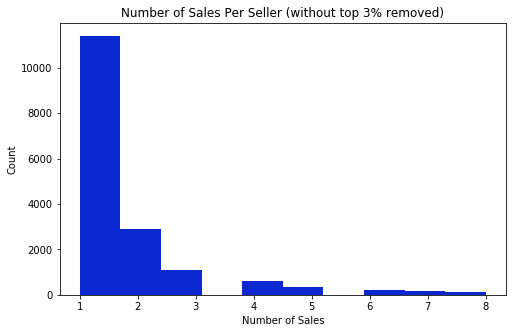

In [217]:
# Average product cost
def product_sales_info(data, olist_blue):
    """
    Identifies number of unique products sold at olist, the average price per product, the
    average number of sales per product. and a list of the top ten products. Plots the 
    distrobution of sales per product.
    """
    
    print(f"Number of unique products: {data.product_id.nunique()}\n")
    print(f"Average price per product: {data.price.mean()}\n")
    
    number_prod_sold = data.product_id.value_counts()
    print(f"Average sales per product: {np.mean(number_prod_sold)}\n")
    
    # top products
    top_ten_products = number_prod_sold[:10]
    print(f"Top ten selling products:\n{top_ten_products}\n")
    print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")

    p_q_97 = number_prod_sold.quantile(.97)
    products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

    plt.figure(figsize=(8,5))
    plt.hist(products_q_97, bins=10, color=olist_blue)
    plt.xlabel('Number of Sales')
    plt.ylabel('Count')
    plt.title('Number of Sales Per Seller (without top 3% removed)');
    
    return

product_sales_info(olist_data, olist_blue)

The top reviewed products are
                              product_id  mean  count
1547   163da86e86f0089de089399c28c3fcbb   5.0     10
692    0a5a41c678bcf81e041826bb24eb0b01   5.0      8
4844   4724ffa427f315c485e39b02e21859b2   5.0      8
5206   4c8b28305f570899b6ded964ddd234a9   5.0      8
5566   51d646c5c93e0f1de543528d0e24eadc   5.0      8
15680  e672fbe634ad07cce9d85f412becb2c0   5.0      8
5562   51ce083cd2b9078656a94655ab45b8a4   5.0      7
6134   59c1840441f4df065f52760bf51a8442   5.0      7
8522   7bcf2266b78ccc737b8f26f925d3c5d4   5.0      7
12233  b30d7b0adcdc4a117f455472548155ec   5.0      7


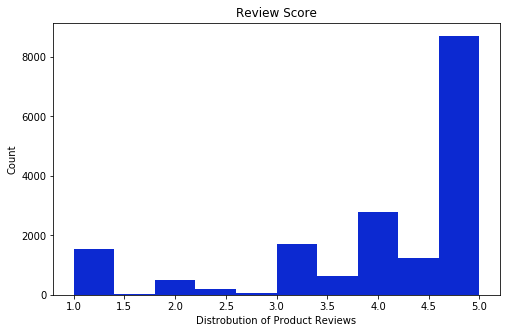

In [218]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    reviewed_products = data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()
    top_ten_reviewed_products = reviewed_products.sort_values(by=['mean','count'],ascending=False)[:10]

    print(f"The top reviewed products are\n {top_ten_reviewed_products}")
    
    return reviewed_products

reviewed_products = product_reviews(olist_data)


plt.figure(figsize=(8,5))
plt.hist(reviewed_products['mean'], bins=10, color=olist_blue)
plt.xlabel('Distrobution of Product Reviews')
plt.ylabel('Count')
plt.title('Review Score');

<Figure size 432x360 with 0 Axes>

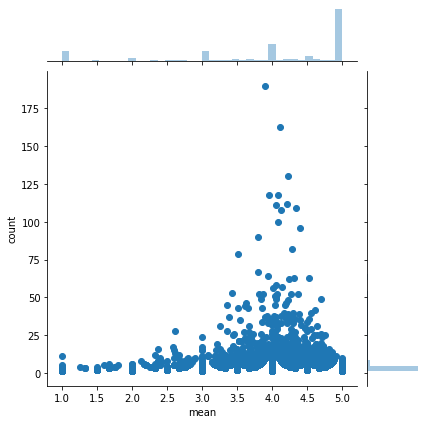

In [219]:
# observe the relationship between rating and number of reviews
fig = plt.figure(figsize=(6,5))
ax = sns.jointplot(x=reviewed_products['mean'], y=reviewed_products['count'], data=reviewed_products);

There are 71 categories


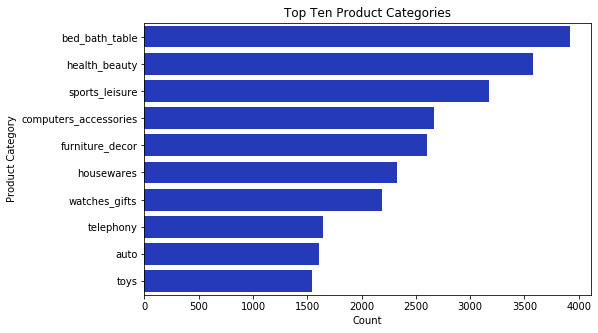

In [220]:
# Product cateogires

def product_categories():
    print(f"There are {olist_data.product_category_name_english.nunique()} categories")

    top_ten_categories = olist_data.product_category_name_english.value_counts().sort_values(ascending=False)[:10]

    plt.figure(figsize=(8,5))
    ax = sns.barplot(top_ten_categories.values, top_ten_categories.index, color=olist_blue)
    ax.set(xlabel='Count', ylabel='Product Category', title='Top Ten Product Categories');
    
    return

product_categories()

# Feature Engineering

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.  

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by "how many predictions are right using the recommender" vs. "how many are right when just recommending the most popular item".  

**For New Users:** Recommendation based on 
* Customer Segmentation, then pick the top product in that customer base
* People in your area, then pick the top products in that customer base   

Results are measured by comparing predictions to the overall most popular item

In [221]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
    
    # Save datasets for easier accessing
    repeaters.to_csv('data/repeater_data1.csv')
    first_timers.to_csv('data/first_timer_data1.csv')
    
    print("Shape of repeater dataset:", repeaters.shape)

    print("Shape of first timer dataset:", first_timers.shape)

    return repeaters, first_timers

In [222]:
repeater_data, first_timer_data = repeat_and_first_time(olist_data)

Shape of repeater dataset: (5404, 20)
Shape of first timer dataset: (33774, 20)


In [223]:
# Unhash to load datasets
repeater_data = pd.read_csv('data/repeater_data1.csv')
first_timer_data = pd.read_csv('data/first_timer_data1.csv')

In [224]:
def regenerate_dataset_with_indicators(repeater_data, first_timer_data):
    repeater_data['repeater'] = 1
    first_timer_data['repeater'] = 0
    
    full_df = pd.concat((repeater_data, first_timer_data), axis=0).drop('Unnamed: 0', axis=1).reset_index()
    print("full_df shape:", full_df.shape)
    full_df.to_csv('data/combined_data1.csv')
    return full_df

full_df = regenerate_dataset_with_indicators(repeater_data, first_timer_data)

full_df shape: (39178, 22)


Additional features are also added to the dataset to explore the delivery process and seller performance.

In [225]:
def full_def_feature_engineering(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp).dt.date
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date).dt.date
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date).dt.date
    
    df = data.copy()
    
    df['days_to_delivery'] = (df.order_delivered_customer_date - data.order_purchase_timestamp).apply(lambda x: x.days) 
    print("Step 1 complete.")
    
    df['estimated_days_to_delivery'] = (df.order_estimated_delivery_date - data.order_purchase_timestamp).apply(lambda x: x.days)
    
    df['days_early_late'] = (df.estimated_days_to_delivery - df.days_to_delivery)#negative = late
    print("Step 2 complete.")    
    
    df['seller_avg_rating'] = df.groupby('seller_id')['review_score'].transform('mean')
    print("Step 3 complete.")
    
    df = df.dropna(axis=0)
    
    return df

feat_eng_full = full_def_feature_engineering(full_df)

#export for tableau visual
feat_eng_full.to_csv('data/feat_engine_full_df.csv')

Step 1 complete.
Step 2 complete.
Step 3 complete.


# Repeat Customers

The full data set is filtered down to only repeat customers. The goal is to predict the customers review on a product they have not purchased. Five methods are tested and compared: using only purchase count, using dummy variables, normalized purchase frequency, user ratings matrix, and normalized user ratings matrix.

## Preparing Dataframes

### Method 1: Purchase Count

In [226]:
def create_puchase_count_df(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination.
    """
    purchase_count = pd.melt(data.set_index('customer_unique_id')['product_id'].apply(pd.Series).reset_index(), 
                 id_vars=['customer_unique_id'],
                 value_name='product_id')
    purchase_count = purchase_count.dropna().drop(['variable'], axis=1)
    purchase_count = purchase_count.groupby(['customer_unique_id', 'product_id']).agg({'product_id': 'count'})
    purchase_count = purchase_count.rename(columns={'product_id': 'estimator'}).reset_index()
    purchase_count = purchase_count.rename(columns={'product_id': 'productId'})
    
    return purchase_count

In [227]:
purchase_count_df = create_puchase_count_df(repeater_data)

In [228]:
purchase_count_df.head()
purchase_count_df.to_csv('data/purchase_count_df.csv')

### Method 2: Dummy Variables

In [229]:
def create_data_dummy(data):
    """
    Creates a dataset with customer_unique_id, _productId, and a binary indicator that the user 
    purchased that product.
    """
    data_dummy = data.copy()
    data_dummy['estimator2'] = 1
    data_dummy = data_dummy.drop('estimator', axis=1)
    data_dummy = data_dummy.rename({'estimator2':'estimator'}, axis=1)
    return data_dummy

In [230]:
dummy_df = create_data_dummy(purchase_count_df)

In [231]:
dummy_df.head()
dummy_df.to_csv('data/dummy_df.csv')

### Method 3: Normalize Purchase Frequency

In [232]:
def normalize_purchase_count(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination, and then normalize the data. 
    """
    count_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())
    count_matrix_norm = count_matrix_norm.reset_index()
    count_matrix_norm.index.names = ['scaled_purchase_freq']
    
    normalized_count_matrix = pd.melt(count_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_count_matrix

In [233]:
normalized_purchase_count_df = normalize_purchase_count(purchase_count_df)

In [234]:
normalized_purchase_count_df.head()
normalized_purchase_count_df.to_csv('data/normalized_purchase_count_df.csv')

### Method 4: User Ratings Matrix

In [235]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
    
#     user_prod_reviewscore_data.avg_rating = user_prod_reviewscore_data.avg_rating.apply(lambda x: 1)
    
    return user_prod_reviewscore_data

In [236]:
user_ratings_df = create_user_ratings_df(repeater_data)

In [237]:
user_ratings_df.head()
user_ratings_df.to_csv('data/user_ratings_df.csv')

### Method 5: Normalized User Ratings Matrix

In [238]:
def normalize_purchase_count(data):
    """Creates a user-ratings matrix but normalizes the ratings data."""
    ratings_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    print(ratings_matrix.head())

    ratings_matrix_norm = (ratings_matrix-ratings_matrix.min())/(ratings_matrix.max()-ratings_matrix.min())
    ratings_matrix_norm = ratings_matrix_norm.reset_index()
    ratings_matrix_norm.index.names = ['estimator']
    
    normalized_ratings_matrix = pd.melt(ratings_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
   
    return normalized_ratings_matrix

In [239]:
normalized_user_ratings_df = normalize_purchase_count(user_ratings_df)

productId                         0011c512eb256aa0dbbb544d8dffcf6e  \
customer_unique_id                                                   
000bfa1d2f1a41876493be685390d6d3                               NaN   
000de6019bb59f34c099a907c151d855                               NaN   
000e309254ab1fc5ba99dd469d36bdb4                               NaN   
001928b561575b2821c92254a2327d06                               NaN   
0025795df7a7d077c4c90162fa820085                               NaN   

productId                         005030ef108f58b46b78116f754d8d38  \
customer_unique_id                                                   
000bfa1d2f1a41876493be685390d6d3                               NaN   
000de6019bb59f34c099a907c151d855                               NaN   
000e309254ab1fc5ba99dd469d36bdb4                               NaN   
001928b561575b2821c92254a2327d06                               NaN   
0025795df7a7d077c4c90162fa820085                               NaN   

productId         

In [240]:
normalized_user_ratings_df.head()

,customer_unique_id,productId,estimator
28371,6b88451897a1732390441060cbb92f0a,014a8a503291921f7b004a5215bb3c36,1.00
28410,700bca91ce2b57d63ac40d9a28097da8,014a8a503291921f7b004a5215bb3c36,1.00
28504,7959ffbef5378bff095bae2150070250,014a8a503291921f7b004a5215bb3c36,1.00
28871,9d841a91b5b7d1451157dbc8cd94ae8e,014a8a503291921f7b004a5215bb3c36,0.25
29516,e28538e3001edb06752b7fc98b6ed97e,014a8a503291921f7b004a5215bb3c36,0.00


## Model Selection

Several different models are tested against each of the datasets created above. The model with the lowest RMSE is selected for additional tuning. 

In [241]:
def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [], [], [], [], []

    normp_mae, svd_mae, knn_mae, co_mae, slope_mae = [], [], [], [], []

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        #trainset.to_csv('data/train_df.csv')
        #testset.to_csv('data/test_df.csv')
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)

        #print(normp_pred)

        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        normp_mae.append(accuracy.mae(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        svd_mae.append(accuracy.mae(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        knn_rmse.append(accuracy.mae(knn_pred,verbose=False))

        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))
        co_mae.append(accuracy.mae(co_pred,verbose=False))
        
        #slope_one
        slope = SlopeOne() 
        slope.fit(trainset)
        slope_pred = slope.test(testset)
        slope_rmse.append(accuracy.rmse(slope_pred,verbose=False))
        slope_mae.append(accuracy.mae(slope_pred,verbose=False))
    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse),
                  np.mean(slope_rmse)]

    mean_maes = [np.mean(normp_mae),
                  np.mean(svd_mae),
                  np.mean(knn_mae),
                  np.mean(co_mae),
                  np.mean(slope_mae)]
    
    model_names = ['baseline', 'svd','knn','coclustering','slopeone']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)

    compare_df1 = pd.DataFrame(mean_maes, index=model_names)
    print(compare_df1)
    
    return compare_df

In [242]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_count', 
                                       'dummy',
                                       'norm_purchase_count', 
                                       'user_ratings', 
                                       'norm_user_ratings']])
    
    return comp_matrix
    

In [243]:
all_methods = [purchase_count_df, dummy_df, normalized_purchase_count_df, user_ratings_df, normalized_user_ratings_df]

In [244]:
comparison_matrix = model_comparison(all_methods)

C:\Users\gulak\Miniconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\gulak\Miniconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
                     0
baseline      0.408543
svd           0.329655
knn                NaN
coclustering  0.333499
slopeone      0.320499
Initial dataframe created.
C:\Users\gulak\Miniconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\gulak\Miniconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\gulak\Miniconda3\envs\myenv\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_

In [245]:
# create a column to indicate percentage better performance than baseline so that 
# centered and non-centered datasets can be compared
comparison_matrix['best_score'] = comparison_matrix.min(axis=1)
comparison_matrix['method_comparison'] = 100*(1-(comparison_matrix.best_score/comparison_matrix.baseline)) 
comparison_matrix

,baseline,svd,knn,coclustering,slopeone,best_score,method_comparison
purchase_count,0.547877,0.414849,0.392144,0.431038,0.422522,0.392144,28.424801
dummy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
norm_purchase_count,0.586221,0.499607,0.467662,0.463885,0.452242,0.452242,22.854672
user_ratings,2.013352,1.377049,1.419660,1.491780,1.407698,1.377049,31.604146
norm_user_ratings,0.573613,0.483316,0.413649,0.455154,0.404165,0.404165,29.540442


Best performer was the user ratings matrix. Although slopeone performed best, svd will be explored using grid search to tune hyperparameters.

## Tuning Winning Model (SVD)

For the final model, will continue to leverage the user rating matrix as it requires minimal computational expense and maximum variance.

### Gridsearch

In [246]:
def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [247]:
# standard svd gridsearch
data = surprise_df(user_ratings_df)

svd_param_grid = {'n_factors': [25, 50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid)

Best score: 1.2929996682138878
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [248]:
# svdpp gridsearch

svdpp_param_grid = {'n_factors': [10, 20, 50],'n_epochs': [20,30,50], 'lr_all': [0.002,0.007,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svdpp_params, svdpp_score = gridsearch(data, SVDpp, svdpp_param_grid)

Best score: 1.2825717950474291
Best params: {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.02}


### Comparing Standard SVD and Funk's SVD

In [249]:
def svd_model(data, model_list, model_names):
    all_scores = []
    
    for model in model_list:
        model_rmse = []
        model_mae = []
        
        for trainset, testset in kf.split(data): #iterate through the folds.

            mod = model
            mod.fit(trainset)
            pred = mod.test(testset)
            model_rmse.append(accuracy.rmse(pred,verbose=False))
            model_mae.append(accuracy.mae(pred,verbose=False))
            
        all_scores.append([np.mean(model_rmse), np.mean(model_mae)])
    
    results = pd.DataFrame(all_scores, index=model_names, columns=['rmse','mae'])
    
    return results  

In [250]:
def svd_comparisons():
    # For comparison, baseline model
    random = NormalPredictor()

    # Standard SVD models
    tuned_svd = SVD(n_factors=svd_params['n_factors'], 
                    n_epochs=svd_params['n_epochs'],
                    lr_all=svd_params['lr_all'], 
                    reg_all=svd_params['reg_all'])

    standard_svd = SVD()

    # SVDpp moddels
    tuned_svdpp = SVDpp(n_factors=svdpp_params['n_factors'], 
                        n_epochs=svdpp_params['n_epochs'],
                        lr_all=svdpp_params['lr_all'], 
                        reg_all=svdpp_params['reg_all'])

    standard_svdpp = SVDpp()


    model_list = [random, tuned_svd, standard_svd, tuned_svdpp, standard_svdpp]
    model_names = ['random','tuned_svd','standard_svd','tuned_svdpp','standard_svdpp']

    return svd_model(data, model_list, model_names)

In [251]:
svd_comparison_df = svd_comparisons()
svd_comparison_df

,rmse,mae
random,2.003416,1.592730
tuned_svd,1.289186,1.107038
standard_svd,1.472608,1.291513
tuned_svdpp,1.281551,1.096229
standard_svdpp,1.435588,1.257221


In [252]:
svdpp_performance = 100*(1-(svd_comparison_df.loc['tuned_svdpp', 'rmse'] / svd_comparison_df.loc['random', 'rmse']))
print(f"Tuned SVDpp performed {svdpp_performance} better than baseline.")

Tuned SVDpp performed 36.031701861822974 better than baseline.


## Final Repeat Customer Model

In [253]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
        
    return user_prod_reviewscore_data

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df



In [254]:
def final_model(data):
    user_product_df = create_user_ratings_df(data)
    user_ratings_matrix = surprise_df(user_product_df)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.2, random_state=19)
    
    params = {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} 
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(repeater_data)

In [255]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

In [256]:
best_predictions = recommendation_results.sort_values(by='err')[:10]
worst_predictions = recommendation_results.sort_values(by='err')[-10:]

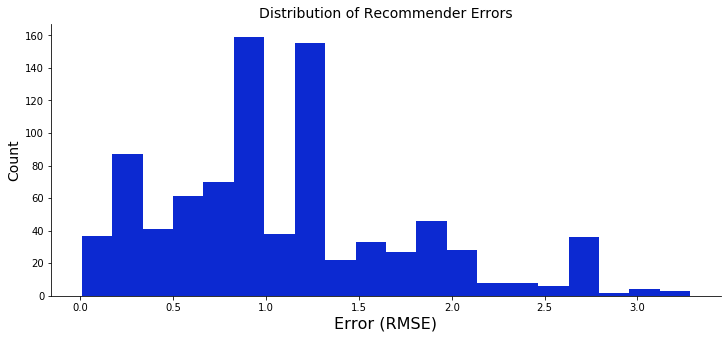

In [264]:
# plot model error
plt.figure(figsize=(12,5))
plt.hist(recommendation_results.err, color=olist_blue, bins=20)
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distribution of Recommender Errors', size=14)
sns.despine();

In [258]:
def means_per_rating_group(dataset):
    real_over_three = dataset[dataset.rui > 3].err
    real_three_under = dataset[dataset.rui <= 3].err
    
    print("Overall recommendation system mean error:", dataset.err.mean())
    print("Mean error for products where user rates above 3:", real_over_three.mean())
    print("Mean error for products where user rates below 3:", real_three_under.mean())
    
    return real_over_three, real_three_under

real_over_three, real_three_under = means_per_rating_group(recommendation_results)

Overall recommendation system mean error: 1.1048639152714537
Mean error for products where user rates above 3: 0.8582308831214507
Mean error for products where user rates below 3: 1.527443876899185


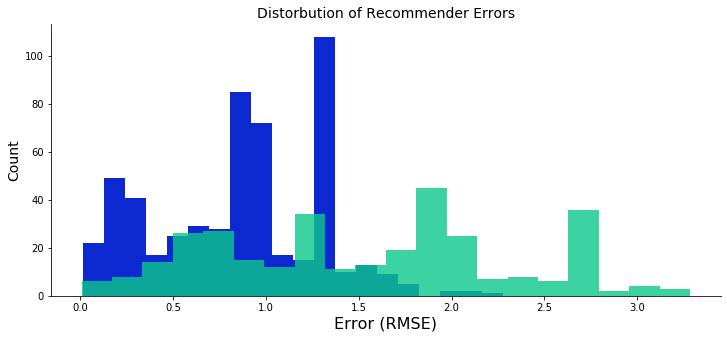

In [259]:
# plot the recommendation system mean for users who rate products higher than 3 and lower than 3
plt.figure(figsize=(12,5))
plt.hist(real_over_three, bins=20, color=olist_blue, label='Actual Rating >3')
plt.hist(real_three_under, bins=20, color=olist_green, alpha=.8, label='Actual Rating <=3')
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();

# First Time Users

First time users are provided a recommendation of hot products on the site as well as popular in your area.

In [260]:
def find_popular_items(data, n_recs):
    top_n_items = data.product_id.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [261]:
def popular_in_your_area(data, state, n_recs):
    location_df = data[data.customer_state == state]
    top_n_items = location_df.product_id.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [262]:
def first_time_recommender(data, uid, n_recs):
    hot_items = find_popular_items(data, n_recs)
    state = data[data.customer_unique_id==uid].customer_state.max()
    popular_in_area = popular_in_your_area(data, state, n_recs)
    
    print(f"Hot items you might like:\n {hot_items}\n")
    print(f"Popular items in your area:\n {popular_in_area}")
    
    recommendation = {'Hot Items': hot_items, 'Area': popular_in_area}
    
    return recommendation

In [263]:
# Example Recommendation
recommendation = first_time_recommender(full_df, 'c71a196d46a70ec611f3922db5755d1d', 3)

Hot items you might like:
 ['99a4788cb24856965c36a24e339b6058', 'aca2eb7d00ea1a7b8ebd4e68314663af', '53b36df67ebb7c41585e8d54d6772e08']

Popular items in your area:
 ['99a4788cb24856965c36a24e339b6058', 'aca2eb7d00ea1a7b8ebd4e68314663af', '154e7e31ebfa092203795c972e5804a6']
